In [1]:
import torch
import fastai
import torchvision
import pandas as pd
import numpy as np
import imutils
import cv2
import matplotlib.pyplot  as plt
import matplotlib.image as mpimg

In [2]:
%matplotlib inline

In [3]:
from torchvision.models import vgg

In [24]:
vgg_model = vgg.vgg19(pretrained=True)
# vgg_model = vgg_model.features
for idx in range(len(vgg_model.features)):
    if isinstance(vgg_model.features[idx], torch.nn.MaxPool2d):
        vgg_model.features[idx] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

In [41]:
conv_indexes = []
for i, layer in enumerate(fastai.children(vgg_model.features)):
    if isinstance(layer, torch.nn.AvgPool2d):
        conv_indexes.append(i-1)
conv_indexes

[3, 8, 17, 26, 35]

In [42]:
img_path = fastai.Path("/Users/alvaro/Downloads/AAEAAQAAAAAAAAd5AAAAJDBiN2RjODUyLTg5YzMtNGI1My1iYmY1LWJhZjQ3ZDRjMDMwZg.jpg")
style_path = fastai.Path("/Users/alvaro/Downloads/gogh_autorretrato_1890_1.jpg")

In [43]:
image = mpimg.imread(img_path)/255
style = mpimg.imread(style_path)/255

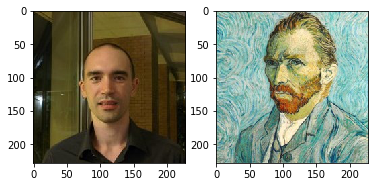

In [44]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(style)

In [45]:
import scipy.ndimage
white_image = torch.rand(*image.shape, requires_grad=True)
white_image = scipy.ndimage.filters.median_filter(white_image.detach().numpy(), [8,8,1])
white_image = torch.from_numpy(white_image)
white_image.requires_grad=True

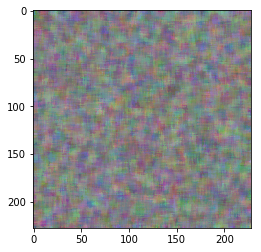

In [46]:
plt.imshow(white_image.detach().cpu().numpy())

In [47]:
# vgg_model(torch.Tensor(i.reshape(1, 3, 224, 224)))

In [48]:
class ForwardHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self)
        self.features = None
    def __call__(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

hooks = [ForwardHook(vgg_model.features[idx]) for idx in conv_indexes]


In [49]:
# [h.remove() for h in hooks]; None

In [50]:
def loss_content(layer_features_image, layer_features_white_image, layer_idx):
    return torch.nn.functional.mse_loss(layer_features_image[layer_idx], layer_features_white_image[layer_idx])

In [51]:
def loss_style(layer_features_image, layer_features_white_image, conv_indexes):
    losses = []
    for idx in conv_indexes:
        num_filters = layer_features_image[idx].size(0)*layer_features_image[idx].size(1)
        G = torch.mm( layer_features_image[idx].view(num_filters, -1), layer_features_image[idx].view(num_filters, -1).t() )
        A = torch.mm( layer_features_white_image[idx].view(num_filters, -1), layer_features_white_image[idx].view(num_filters, -1).t() )
        loss = torch.nn.functional.mse_loss(G, A) / (4*(layer_features_image[idx].size(0)**2)*(layer_features_image[idx].size(1)**2)*100)
        losses.append(loss)
        
    return sum(losses)

In [52]:
optim = torch.optim.Adam([white_image], lr=0.5)

vgg_model.features(torch.Tensor(image.transpose(2, 0, 1)[None])); None
image_features = [h.features.detach().clone() for h in hooks]
# for f in image_features: f.requires_grad = False

vgg_model.features(torch.Tensor(style.transpose(2, 0, 1)[None])); None
style_features = [h.features.detach().clone() for h in hooks]
# for f in style_features: f.requires_grad = False

In [53]:
optim = torch.optim.LBFGS([white_image], lr=0.5, max_iter=5)

In [54]:
def step():
    vgg_model.features(white_image.permute(2, 0, 1).unsqueeze(dim=0)); None
    white_image_features = [h.features.clone() for h in hooks]

    optim.zero_grad()
    l1 = loss_content(image_features, white_image_features, -3)/100
    l2 = loss_style(style_features, white_image_features, list(range(len(conv_indexes)))[:-1])
    loss = l1 + l2
    print(loss.data, l1.data, l2.data)
    loss.backward()
    # optim.step()
    return loss

tensor(84719.7344) tensor(8932.3203) tensor(75787.4141)
tensor(84712.4453) tensor(8932.4209) tensor(75780.0234)
tensor(134120095744.) tensor(251770.8594) tensor(134119841792.)
tensor(8875660288.) tensor(73586.3828) tensor(8875586560.)
tensor(6574936064.) tensor(64886.3398) tensor(6574871040.)


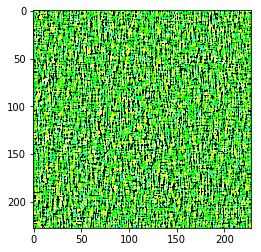

In [55]:
for i in range(1):
    optim.step(lambda: step())
    plt.imshow(white_image.detach().cpu().numpy())

In [20]:
# for i in range(30):
#     vgg_model.features(white_image.permute(2, 0, 1).unsqueeze(dim=0)); None
#     white_image_features = [h.features.clone() for h in hooks]
# 
#     optim.zero_grad()
#     l1 = loss_content(image_features, white_image_features, -3)
#     l2 = loss_style(style_features, white_image_features, range(len(conv_indexes)))
#     loss = l1 + l2
#     print(loss.data, l1.data, l2.data)
#     loss.backward()
#     optim.step()
# 
# plt.imshow(white_image.detach().cpu().numpy())

In [21]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)